In [9]:
import os
import torch
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix


In [2]:
class WheatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['healthy', 'sick']
        self.image_paths = []
        self.labels = []

        if not os.path.exists(root_dir):
            raise ValueError(f"Directory {root_dir} does not exist!")
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"Warning: {class_dir} not found, skipping...")
                continue
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.png', '.jpeg', '.jfif')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(label)

        if len(self.image_paths) == 0:
            raise ValueError(f"No valid images found in {root_dir}!")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')  # Исправлено Image -> image

            if self.transform:
                image = self.transform(image)  # Image -> image
            
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None


In [3]:
dataset = '/kaggle/input/wheatdataset/dataset/HealthySickWheat'
train_dir = '/kaggle/input/wheatdataset/dataset/HealthySickWheat/train'
test_dir = '/kaggle/input/wheatdataset/dataset/HealthySickWheat/test'

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10),     
    transforms.ToTensor(),              
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = WheatDataset(root_dir=train_dir, transform = train_transforms)
test_dataset = WheatDataset(root_dir=train_dir, transform = test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32 ,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32 ,shuffle=False)

In [4]:
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.fc = torch.nn.Linear(model.fc.in_features, 2)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 220MB/s]


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
def Train(model, dataloader, criterion, optimizer, epochs, device):
    model.train()

    train_losses = []
    train_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0
        correct = 0 
        total = 0
        for inputs, labels in tqdm(dataloader, desc='Training', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
        epoch_loss = running_loss / total
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f"Epoch: {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuarcy: {epoch_acc:.2f}")

        plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy")
    plt.legend()

    plt.show()

In [11]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Сохраняем предсказания и истинные метки для матрицы ошибок
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    print(f'Evaluate: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%')

    # Построение матрицы ошибок
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'Sick'], yticklabels=['Healthy', 'Sick'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
Train(model, train_loader, criterion , optimizer, 50,device)

Epoch: 1/50, Loss: 0.4913, Accuarcy: 78.80


Epoch: 2/50, Loss: 0.3470, Accuarcy: 86.09


Epoch: 3/50, Loss: 0.3336, Accuarcy: 86.82


Epoch: 4/50, Loss: 0.3016, Accuarcy: 87.22


Epoch: 5/50, Loss: 0.2777, Accuarcy: 89.30


Epoch: 6/50, Loss: 0.2538, Accuarcy: 91.04


Epoch: 7/50, Loss: 0.2416, Accuarcy: 91.30


Epoch: 8/50, Loss: 0.2247, Accuarcy: 91.17


Epoch: 9/50, Loss: 0.2525, Accuarcy: 90.97


Epoch: 10/50, Loss: 0.2207, Accuarcy: 91.10


Epoch: 11/50, Loss: 0.1972, Accuarcy: 92.71


Epoch: 12/50, Loss: 0.1880, Accuarcy: 93.04


Epoch: 13/50, Loss: 0.1670, Accuarcy: 94.11


Epoch: 14/50, Loss: 0.1535, Accuarcy: 94.45


Epoch: 15/50, Loss: 0.1432, Accuarcy: 94.52


Epoch: 16/50, Loss: 0.1714, Accuarcy: 93.31


Epoch: 17/50, Loss: 0.1864, Accuarcy: 93.44


Epoch: 18/50, Loss: 0.1688, Accuarcy: 93.31


Epoch: 19/50, Loss: 0.1094, Accuarcy: 95.99


Epoch: 20/50, Loss: 0.1489, Accuarcy: 93.51


<ipython-input-10-29c3cfaacf40>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 5))


Epoch: 21/50, Loss: 0.1200, Accuarcy: 95.38


Epoch: 22/50, Loss: 0.1137, Accuarcy: 96.05


Epoch: 23/50, Loss: 0.1364, Accuarcy: 94.92


Epoch: 24/50, Loss: 0.1201, Accuarcy: 95.32


Epoch: 25/50, Loss: 0.1299, Accuarcy: 95.45


Epoch: 26/50, Loss: 0.1367, Accuarcy: 95.65


Epoch: 27/50, Loss: 0.1263, Accuarcy: 95.45


Epoch: 28/50, Loss: 0.0890, Accuarcy: 97.26


Epoch: 29/50, Loss: 0.0865, Accuarcy: 96.99


Epoch: 30/50, Loss: 0.0814, Accuarcy: 96.99


Epoch: 31/50, Loss: 0.0995, Accuarcy: 96.25


Epoch: 32/50, Loss: 0.0696, Accuarcy: 97.32


Epoch: 33/50, Loss: 0.0850, Accuarcy: 96.79


Epoch: 34/50, Loss: 0.1214, Accuarcy: 95.52


Epoch: 35/50, Loss: 0.1123, Accuarcy: 95.85


Epoch: 36/50, Loss: 0.0761, Accuarcy: 97.59


Training:  26%|██▌       | 12/47 [00:07<00:21,  1.65it/s]

Evaluate: Loss = 0.0626, Accuracy = 97.79%


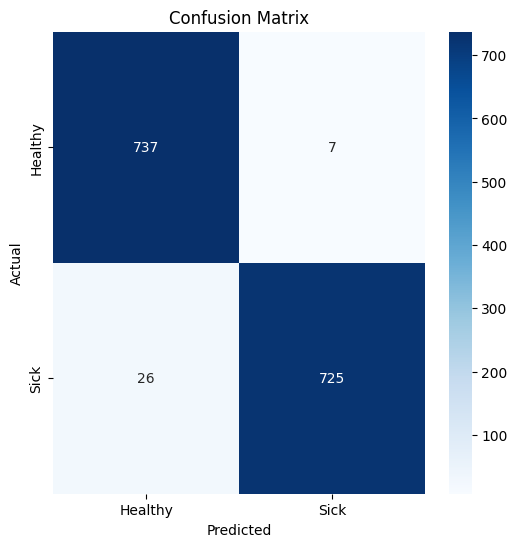

In [34]:
evaluate(model, test_loader, criterion, device)

In [35]:
torch.save(model.state_dict(), "model.pth")
print("Модель сохранена!")


Модель сохранена!
